## Import

In [1]:
import os
import cv2
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
# !pip install segmentation_models_pytorch
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
# from google.colab import drive
# !pip install transformers

In [2]:
# drive.mount('/content/drive')
from transformers import SamModel, SamProcessor, SamImageProcessor
import segmentation_models_pytorch as smp
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# !pip install monai

c:\Users\user\anaconda3\envs\DeMa\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [3]:
# cd drive/MyDrive/building_segmentation

In [4]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

NameError: ignored

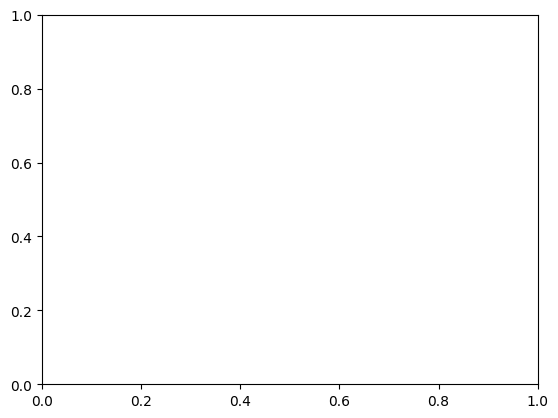

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
ground_truth_seg = np.array(example["label"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [5]:
def create_prompt(ground_truth_mask):
    y_indices, x_indices = np.where(ground_truth_mask == 1)
    print(y_indices)
    print(x_indices)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_mask.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

## Utils

In [6]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, processor=None, transform = None, infer=False):
        self.data = pd.read_csv(csv_file)
        self.processor = processor
        self.infer = infer
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))
        bbox = create_prompt(mask)

        resize = self.transform(image = image, mask = mask)
        mask = resize["mask"]

        augmented = self.processor(image, input_boxes=[[bbox]], return_tensors="pt")
        augmented = {k:v.squeeze(0) for k,v in augmented.items()}
        augmented["mask"] = mask

        return augmented

## Custom Dataset

In [7]:
from transformers import SamImageProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
transform = A.Compose(
    [
        A.Resize(256, 256),
        ToTensorV2()
    ]
)
train_csv_path = "train.csv"
dataset = SatelliteDataset(train_csv_path, processor=processor, transform = transform)
train_dataset_length = int(len(dataset) * 0.9)
validation_dataset_length = int(len(dataset) * 0.1)

train_dataset, validation_dataset = random_split(dataset, [train_dataset_length, validation_dataset_length])

train_dataloader = DataLoader(train_dataset, batch_size=12, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=12, shuffle=True)

## Data Loader

## Define Model

In [8]:
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

model.to(device)

c:\Users\user\anaconda3\envs\DeMa\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [9]:
import monai
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
# loss function과 optimizer 정의
criterion = torch.nn.BCEWithLogitsLoss()
Dice_Loss = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# training loop
model.train()
for epoch in range(5):  # 10 에폭 동안 학습합니다.
    train_loss = 0
    for input in tqdm(train_dataloader):
        masks = input["mask"].float().to(device)

        optimizer.zero_grad()
        outputs = model(pixel_values=input["pixel_values"].to(device),
                      input_boxes=input["input_boxes"].to(device),
                      multimask_output=False)

        predicted_masks = outputs.pred_masks.squeeze(1)
        loss = seg_loss(predicted_masks, masks.unsqueeze(1))
        score = 1 - loss
        print("dice score result: ")
        print(score)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        torch.cuda.empty_cache()

    val_loss = 0
    with torch.no_grad():
        model.eval()
        for val_input in tqdm(validation_dataloader):
            masks = val_input["mask"].float().to(device)

            optimizer.zero_grad()
            outputs = model(pixel_values=val_input["pixel_values"].to(device),
                      input_boxes=val_input["input_boxes"].to(device),
                      multimask_output=False)

            validation_predicted_masks = outputs.pred_masks.squeeze(1)
            loss = seg_loss(validation_predicted_masks, masks.unsqueeze(1))
            score = 1- loss
            print(score.cpu)
            val_loss += loss.item()


    print(f'Epoch {epoch+1}, Loss: {train_loss/len(train_dataloader)}')
    print(f'Epoch {epoch+1}, Loss: {val_loss/len(validation_dataloader)}')

  0%|          | 0/536 [00:00<?, ?it/s]

[  0   0   0 ... 834 834 834]
[555 556 557 ... 459 460 461]
[  21   21   21 ... 1023 1023 1023]
[617 618 619 ... 786 787 788]
[  15   15   15 ... 1023 1023 1023]
[423 424 425 ... 791 792 793]
[   0    0    0 ... 1023 1023 1023]
[25 26 27 ... 83 84 85]
[   0    0    0 ... 1023 1023 1023]
[ 96  97  98 ... 786 787 788]
[   0    0    0 ... 1023 1023 1023]
[758 759 760 ...  92  93  94]
[   0    0    0 ... 1023 1023 1023]
[683 684 685 ... 616 617 618]
[   0    0    0 ... 1023 1023 1023]
[  0   1   2 ... 942 943 944]
[   0    0    0 ... 1023 1023 1023]
[430 431 432 ... 446 447 448]
[  0   0   0 ... 970 970 971]
[467 468 469 ... 879 880 880]
[   3    3    3 ... 1023 1023 1023]
[ 38  39  40 ... 867 868 869]
[  2   2   2 ... 788 788 789]
[356 357 358 ... 890 891 887]


  0%|          | 0/536 [00:22<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 9.00 GiB (GPU 0; 12.00 GiB total capacity; 19.96 GiB already allocated; 0 bytes free; 20.19 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Model Train

## Inference

## Submission